In [1]:
import lightning as L
from lightning.pytorch.callbacks import RichProgressBar
from lightning.pytorch.callbacks.progress.rich_progress import RichProgressBarTheme

from multimodal_bridge_matching import MultiModalBridgeMatching
from utils.dataloader import DataloaderModule
from data.particle_clouds.jets import JetDataclass

progress_bar = RichProgressBar(
    theme=RichProgressBarTheme(
        description="green_yellow",
        progress_bar="green1",
        progress_bar_finished="green1",
        progress_bar_pulse="#6206E0",
        batch_progress="green_yellow",
        time="grey82",
        processing_speed="grey82",
        metrics="grey82",
        metrics_text_delimiter="\n",
        metrics_format=".3e",
    )
)

In [2]:
path = "/home/df630/Multimodal-Bridges/experiments/lightning_logs/version_0"
ckpt = "/checkpoints/epoch=999-step=79000.ckpt"

bridge = MultiModalBridgeMatching.load_from_checkpoint(path + ckpt)

config = bridge.hparams.config
config.experiment.work_dir = path
config.experiment.run_name = "aoj_generation"
config.data.target.path = "/home/df630/CMB/data/AOJ/2016H_job3.h5"
config.data.target.params.num_jets = 20_000
config.train.data_split_frac = [1.0, 0.0, 0.0]

/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")


In [3]:
jets = JetDataclass(config=config)
jets.preprocess()

dataloader = DataloaderModule(config=config, dataclass=jets)

model = L.Trainer(
    log_every_n_steps=5,
    accelerator="gpu",
    devices=[1],
    callbacks=[progress_bar],
)

/home/df630/Multimodal-Bridges/multimodal_bridges/data/particle_clouds/utils.py:250: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  discrete = torch.tensor(discrete).long()
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


INFO: building dataloaders...
INFO: train/val/test split ratios: 1.0/0.0/0.0
INFO: train size: 20000, validation size: 0, testing sizes: 0


In [4]:
from multimodal_bridge_matching import BridgeState
from data.particle_clouds.particles import ParticleClouds

generation = model.predict(bridge, dataloaders=dataloader.train)
sample = BridgeState.cat(generation)
gen_sample = ParticleClouds(dataset=sample)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `predict_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/df630/.conda/envs/conditional_rate_matching/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.


Output()

In [5]:
gen_sample.postprocess(
    input_continuous=config.data.target.preprocess.continuous,
    input_discrete=config.data.target.preprocess.discrete,
    stats=config.data.target.preprocess.stats,
)

jets.postprocess()


In [33]:
from data.particle_clouds.jets import JetClassHighLevelFeatures

gen_jets = JetClassHighLevelFeatures(constituents=gen_sample)
test_jets = JetClassHighLevelFeatures(constituents=jets.target)


Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination


Calculating N-subjettiness
Calculating D2
Clustering jets with fastjet
Jet definition: Longitudinally invariant kt algorithm with R = 0.8 and E scheme recombination
Calculating N-subjettiness
Calculating D2


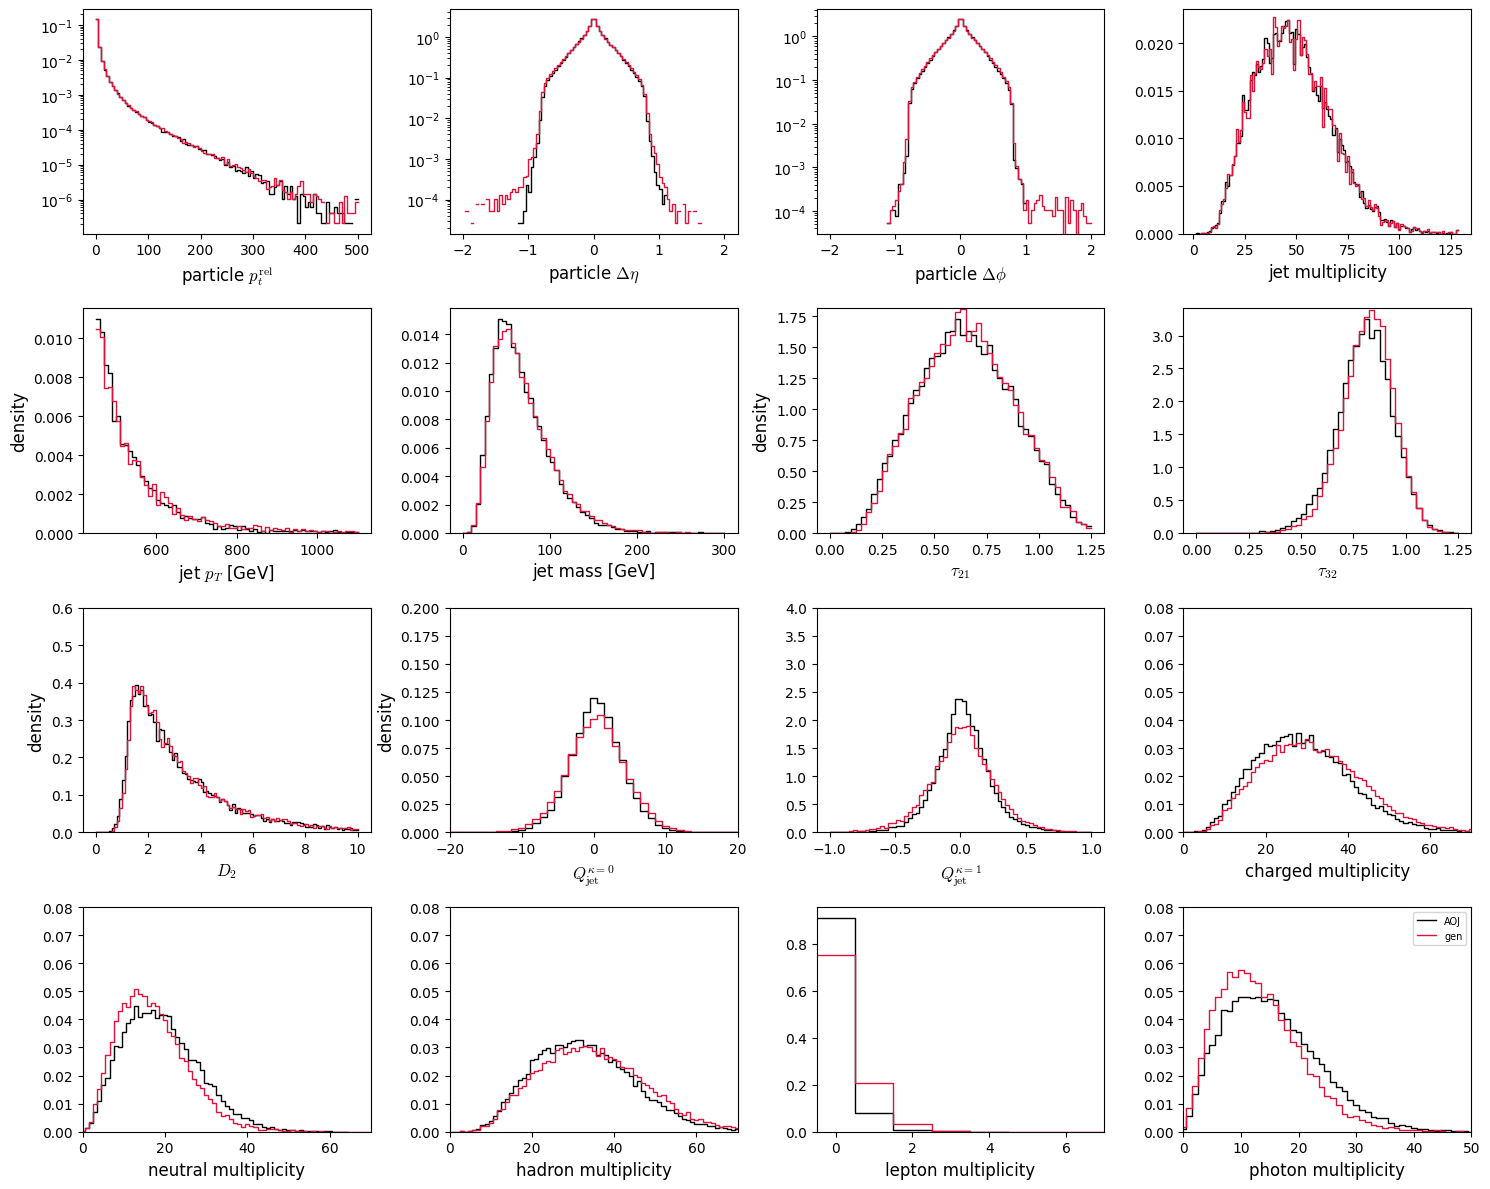

In [46]:
_, ax = plt.subplots(4,4,figsize=(15,12))

arg_test = dict(stat='density', fill=False, log_scale=(False, False), color='k', lw=1.0, label='AOJ')
arg_gen = dict(stat='density', fill=False,log_scale=(False, False), color='crimson', lw=1.0, label='gen')
arg_test_log = dict(stat='density', fill=False, log_scale=(False, True), color='k', lw=1.0, label='AOJ')
arg_gen_log = dict(stat='density', fill=False,log_scale=(False, True), color='crimson', lw=1.0, label='gen')

binrange, binwidth = (0, 500), 5
test_jets.constituents.histplot('pt', binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_test_log)
gen_jets.constituents.histplot('pt', binrange=binrange, binwidth=binwidth, xlabel=r'particle $p_t^{\rm rel}$', ax=ax[0,0], **arg_gen_log)

binrange, binwidth = (-2, 2), 0.04
test_jets.constituents.histplot('eta_rel',  binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_test_log)
gen_jets.constituents.histplot('eta_rel', binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \eta$', ax=ax[0,1], **arg_gen_log)

binrange, binwidth = (-2, 2), 0.04
test_jets.constituents.histplot('phi_rel',  binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_test_log)
gen_jets.constituents.histplot('phi_rel',  binrange=binrange, binwidth=binwidth, xlabel=r'particle $\Delta \phi$', ax=ax[0,2], **arg_gen_log)


test_jets.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_test)
gen_jets.histplot_multiplicities(xlabel='jet multiplicity', ax=ax[0,3], **arg_gen)

# ------------------------------

binrange, binwidth = (450, 1100), 10
test_jets.histplot('pt',  xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('pt', xlabel=r'jet $p_T$ [GeV]', ylabel='density', ax=ax[1,0], binrange=binrange, binwidth=binwidth, **arg_gen)

binrange, binwidth = (0, 300), 5
test_jets.histplot('m',  xlabel=r'jet mass [GeV]', ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('m', xlabel=r'jet mass [GeV]', ax=ax[1,1], binrange=binrange, binwidth=binwidth, **arg_gen)

binrange, binwidth, ylim = (0, 1.25), 0.025, (0, 4.0)
test_jets.histplot('tau21',  xlabel=r'$\tau_{21}$', ylabel='density', ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('tau21', xlabel=r'$\tau_{21}$', ylabel='density', ax=ax[1,2], binrange=binrange, binwidth=binwidth, **arg_gen)

test_jets.histplot('tau32',  xlabel=r'$\tau_{32}$', ax=ax[1,3], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('tau32', xlabel=r'$\tau_{32}$', ax=ax[1,3], binrange=binrange, binwidth=binwidth, **arg_gen)


# ------------------------------

binrange, binwidth, ylim = (0, 10.0), 0.1, (0, .6)
test_jets.histplot('d2',  xlabel=r'$D_2$', ylabel='density', ax=ax[2,0], binrange=binrange, binwidth=binwidth, **arg_test)
gen_jets.histplot('d2', xlabel=r'$D_2$', ylabel='density', ax=ax[2,0],  ylim=ylim, binrange=binrange, binwidth=binwidth, **arg_gen)

xlim, ylim = (-20, 20), (0, 0.2)
test_jets.histplot('Q_total', xlabel=r'$Q_{\rm jet}^{\kappa=0}$',  discrete=True, ax=ax[2,1], **arg_test)
gen_jets.histplot('Q_total', xlabel=r'$Q_{\rm jet}^{\kappa=0}$', ylim=ylim, xlim=xlim, ylabel='density', discrete=True, ax=ax[2,1], **arg_gen)

binrange, binwidth, ylim = (-1, 1), 0.03, (0.0, 4.0)
test_jets.histplot('Q_jet', xlabel=r'$Q_{\rm jet}^{\kappa=1}$', binrange=binrange, binwidth=binwidth , ax=ax[2,2], **arg_test)
gen_jets.histplot('Q_jet', xlabel=r'$Q_{\rm jet}^{\kappa=1}$', ylim=ylim, binrange=binrange, binwidth=binwidth, ax=ax[2,2], **arg_gen)

xlim, ylim = (0, 70), (0, 0.08)
test_jets.histplot_multiplicities(state=[2,3,4,5,6,7], xlabel='charged multiplicity', ax=ax[2,3], **arg_test)
gen_jets.histplot_multiplicities(state=[2,3,4,5,6,7], xlabel='charged multiplicity', xlim=xlim, ylim=ylim, ax=ax[2,3], **arg_gen)

xlim, ylim = (0, 70), (0, 0.08)
test_jets.histplot_multiplicities(state=[0,1], xlabel='neutral multiplicity', ax=ax[3,0], **arg_test)
gen_jets.histplot_multiplicities(state=[0,1], xlabel='neutral multiplicity', xlim=xlim, ylim=ylim, ax=ax[3,0], **arg_gen)

xlim, ylim = (0, 70), (0, 0.08)
test_jets.histplot_multiplicities(state=[1,2,3], xlabel='hadron multiplicity', ax=ax[3,1], **arg_test)
gen_jets.histplot_multiplicities(state=[1,2,3], xlabel='hadron multiplicity', xlim=xlim, ylim=ylim, ax=ax[3,1], **arg_gen)

xlim, ylim = (-0.5,7), (0, 1.25)
test_jets.histplot_multiplicities(state=[4,5,6,7], xlabel='lepton multiplicity', ax=ax[3,2], **arg_test)
gen_jets.histplot_multiplicities(state=[4,5,6,7], xlabel='lepton multiplicity', xlim=xlim, ax=ax[3,2], **arg_gen)   

xlim, ylim = (0, 50), (0, 0.08)
test_jets.histplot_multiplicities(state=0, xlabel='photon multiplicity', ax=ax[3,3], **arg_test)
gen_jets.histplot_multiplicities(state=0, xlabel='photon multiplicity', xlim=xlim, ylim=ylim, ax=ax[3,3], **arg_gen)

plt.legend(fontsize=7)
plt.tight_layout()
